# Importing Libraries

In [26]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.4.1


# Preparing Training and Test Sets

In [27]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

# List the contents of the root directory for debugging
print(f"Contents of {root_dir}: {os.listdir(root_dir)}")

# Check if the source directories exist or if they have already been renamed
if os.path.isdir(os.path.join(root_dir, source_dirs[1])) or os.path.isdir(os.path.join(root_dir, class_names[1])):
    test_dir = os.path.join(root_dir, 'test')
    
    # Create the test directory if it doesn't exist
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
        print(f"Created test directory: {test_dir}")
    else:
        print(f"Test directory already exists: {test_dir}")

    # Rename source directories to class names if they haven't been renamed yet
    for i, d in enumerate(source_dirs):
        src_path = os.path.join(root_dir, d)
        dest_path = os.path.join(root_dir, class_names[i])
        if os.path.exists(src_path):
            os.rename(src_path, dest_path)
            print(f"Renamed {src_path} to {dest_path}")
        else:
            print(f"Source directory {src_path} does not exist or has already been renamed.")

    # Create class subdirectories in the test directory
    for c in class_names:
        class_test_dir = os.path.join(test_dir, c)
        if not os.path.exists(class_test_dir):
            os.mkdir(class_test_dir)
            print(f"Created directory for class {c}: {class_test_dir}")
        else:
            print(f"Directory for class {c} already exists: {class_test_dir}")

    # List the contents of each class directory for debugging
    for c in class_names:
        class_dir = os.path.join(root_dir, c)
        if os.path.exists(class_dir):
            print(f"Contents of {class_dir}: {os.listdir(class_dir)}")
        else:
            print(f"Class directory {class_dir} does not exist.")

    # Select and move images to the test directory
    for c in class_names:
        class_dir = os.path.join(root_dir, c, 'images')
        if not os.path.exists(class_dir):
            print(f"Images directory {class_dir} does not exist.")
            continue
        images = [x for x in os.listdir(class_dir) if x.lower().endswith('png')]
        print(f"Found {len(images)} images in class {c}")
        if len(images) < 30:
            print(f"Not enough images in class {c} to sample 30 images. Skipping this class.")
            continue
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(class_dir, image)
            target_path = os.path.join(test_dir, c, image)
            shutil.move(source_path, target_path)
            print(f"Moved {source_path} to {target_path}")
else:
    print(f"Source directories {source_dirs} do not exist.")

Contents of COVID-19_Radiography_Dataset: ['Lung_Opacity.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'test', 'COVID.metadata.xlsx', 'Normal.metadata.xlsx', 'Lung_Opacity', 'normal', 'viral', 'covid', 'README.md.txt']
Test directory already exists: COVID-19_Radiography_Dataset/test
Renamed COVID-19_Radiography_Dataset/Normal to COVID-19_Radiography_Dataset/normal
Source directory COVID-19_Radiography_Dataset/Viral Pneumonia does not exist or has already been renamed.
Renamed COVID-19_Radiography_Dataset/COVID to COVID-19_Radiography_Dataset/covid
Directory for class normal already exists: COVID-19_Radiography_Dataset/test/normal
Directory for class viral already exists: COVID-19_Radiography_Dataset/test/viral
Directory for class covid already exists: COVID-19_Radiography_Dataset/test/covid
Contents of COVID-19_Radiography_Dataset/normal: ['images', 'masks']
Contents of COVID-19_Radiography_Dataset/viral: ['images', 'masks']
Contents of COVID-19_Radiography_Dataset/covid: ['images',

# Creating Custom Dataset


In [28]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [29]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [36]:
train_dirs = {
    'normal': f'{root_dir}/{class_names[0]}/images',
    'viral': f'{root_dir}/{class_names[1]}/images',
    'covid': f'{root_dir}/{class_names[2]}/images'
}

# Check if directories exist
for class_name, dir_path in train_dirs.items():
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10132 normal examples
Found 1285 viral examples
Found 3556 covid examples


In [38]:
test_dirs = {
    'normal': f'{root_dir}/test/{class_names[0]}',
    'viral': f'{root_dir}/test/{class_names[1]}',
    'covid': f'{root_dir}/test/{class_names[2]}'
}

# Check if directories exist
for class_name, dir_path in test_dirs.items():
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 60 normal examples
Found 60 viral examples
Found 60 covid examples


In [39]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2496
Number of test batches 30


# Data Visualization

In [40]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

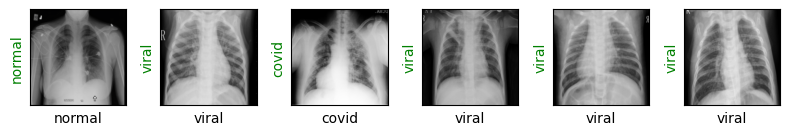

In [41]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

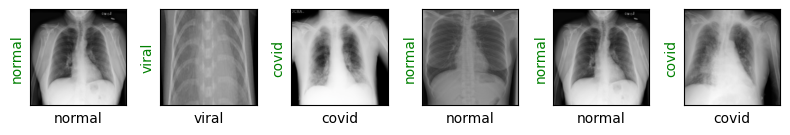

In [42]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [43]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/safwanislam/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 9.05MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [45]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

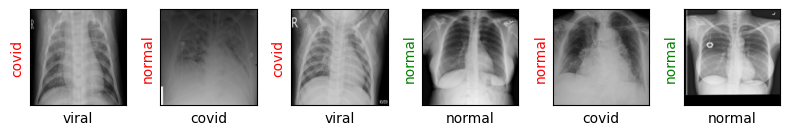

In [46]:
show_preds()

# Training Model

In [49]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase​
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                accuracy = 0
                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                show_preds()

                resnet18.train()
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0728, Accuracy: 0.3944


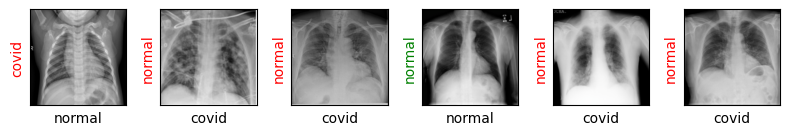

Evaluating at step 20
Validation Loss: 0.7556, Accuracy: 0.6944


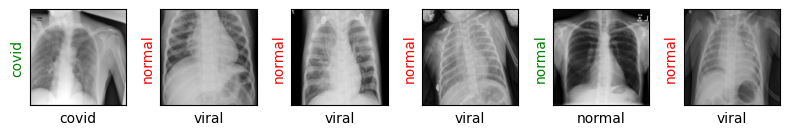

Evaluating at step 40
Validation Loss: 0.5268, Accuracy: 0.8444


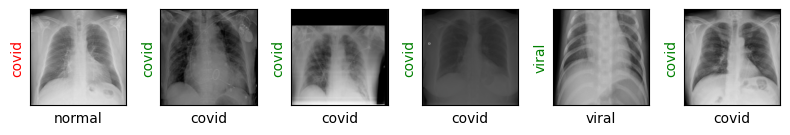

Evaluating at step 60
Validation Loss: 0.3497, Accuracy: 0.8778


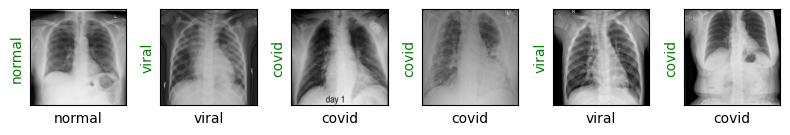

Evaluating at step 80
Validation Loss: 0.3521, Accuracy: 0.8833


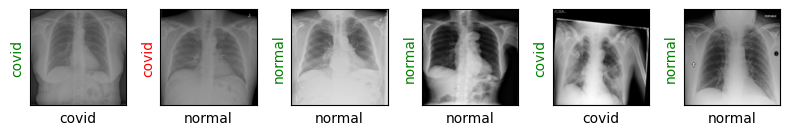

Evaluating at step 100
Validation Loss: 0.2983, Accuracy: 0.8944


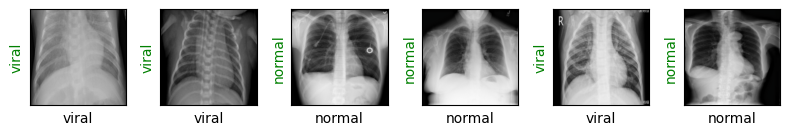

Evaluating at step 120
Validation Loss: 0.2900, Accuracy: 0.8778


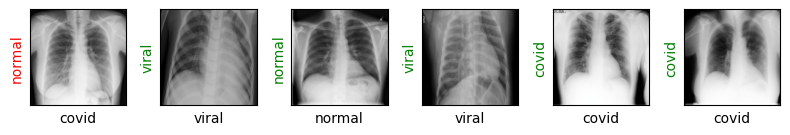

Evaluating at step 140
Validation Loss: 0.2090, Accuracy: 0.9333


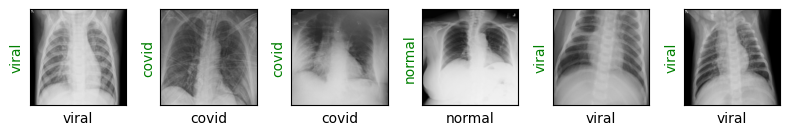

Evaluating at step 160
Validation Loss: 0.2410, Accuracy: 0.9278


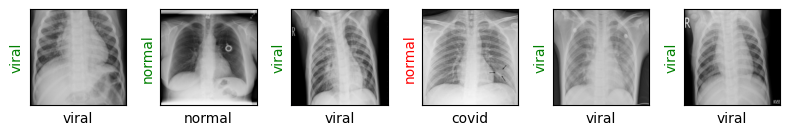

Evaluating at step 180
Validation Loss: 0.2162, Accuracy: 0.9111


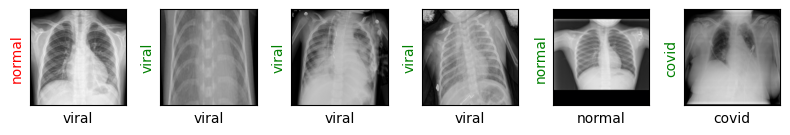

Evaluating at step 200
Validation Loss: 0.1656, Accuracy: 0.9167


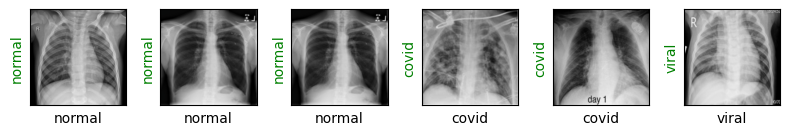

Evaluating at step 220
Validation Loss: 0.1966, Accuracy: 0.9000


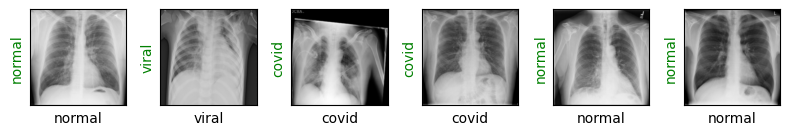

Evaluating at step 240
Validation Loss: 0.3265, Accuracy: 0.8444


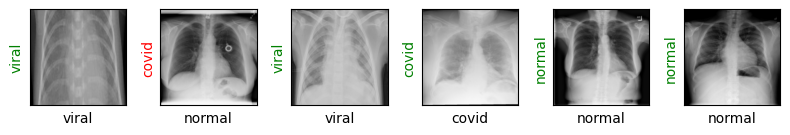

Evaluating at step 260
Validation Loss: 0.2153, Accuracy: 0.9333


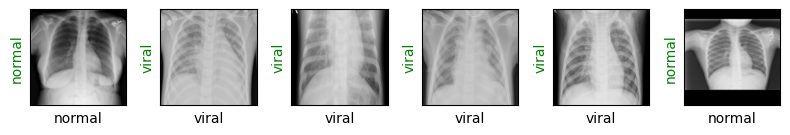

Evaluating at step 280
Validation Loss: 0.1894, Accuracy: 0.9389


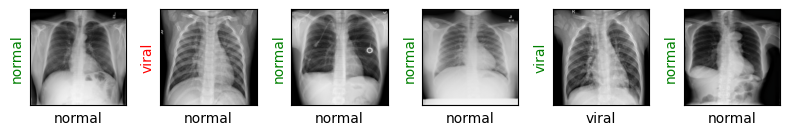

Evaluating at step 300
Validation Loss: 0.2428, Accuracy: 0.9056


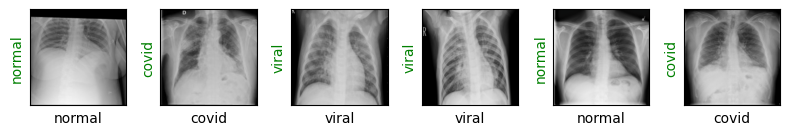

Evaluating at step 320
Validation Loss: 0.2178, Accuracy: 0.9222


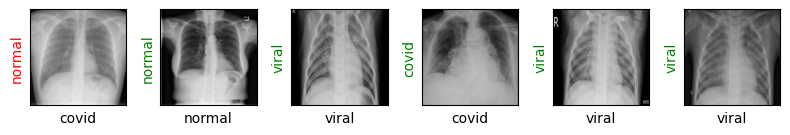

Evaluating at step 340
Validation Loss: 0.1569, Accuracy: 0.9556


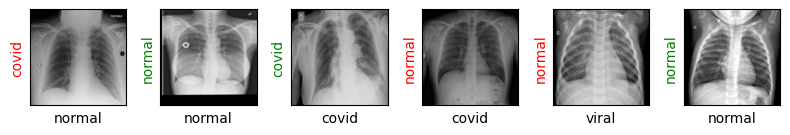

Performance condition satisfied, stopping..
CPU times: user 10min 43s, sys: 1min 13s, total: 11min 56s
Wall time: 2min 24s


In [50]:
%%time

train(epochs=1)

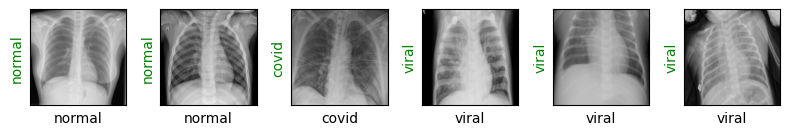

In [51]:
show_preds()